In [2]:
from mewpy.io import Reader, Engines, read_model, read_json
from mewpy.germ.analysis import get_real_initial_state, ifva, SRFBA, FBA
import pandas as pd
import os
import numpy as np
import re

In [3]:
import re

In [4]:
generic_sbml_fname = "..\\data\\models\\sirt1_recon3d\\Recon3D_SIRT1_generic_gpr_fix.xml"
trn_fname = "..\\data\\pypath\\grouped_sirt1_trn_manually_curated.csv"

In [5]:
trn_reader = Reader(Engines.BooleanRegulatoryCSV,
                            trn_fname, sep=',', id_col=0, rule_col=1, header=0)
generic_recon_reader = Reader(Engines.MetabolicSBML, generic_sbml_fname)

generic_model = read_model(generic_recon_reader, trn_reader)

In [6]:
import pandas as pd

In [7]:
irreversibles = list(pd.read_excel("..\\data\\reaction_constraints\\irreversible.xlsx", header=None)[0])

In [8]:
closed = list(pd.read_excel("..\\data\\reaction_constraints\\closed.xlsx", header=None)[0])

In [9]:
diets = pd.read_excel("..\\data\\diets\\NewDiets.xlsx").set_index("Index")

In [10]:
diet = diets.to_dict()["High-fat diet"]

In [11]:
for rxn in generic_model.reactions.keys():
    rxn_name = rxn
    if re.search(r"^EX", rxn_name):
        if rxn_name in diet:
            generic_model.get(rxn_name).bounds = (-1 * diet[rxn_name], 1000)
        else:
            generic_model.get(rxn_name).bounds = (0, 1000)
    elif re.search("sink", rxn) or rxn_name in closed:
        generic_model.get(rxn_name).bounds = (0,0)
    elif rxn_name in irreversibles:
        generic_model.get(rxn_name).bounds = (0,1000)

In [12]:
for rxn in generic_model.reactions.keys():
    rxn_name = rxn
    if re.search(r"^EX", rxn_name):
        if rxn_name in diet:
            print(rxn_name, generic_model.get(rxn_name).bounds)
        else:
            print(rxn_name, generic_model.get(rxn_name).bounds)
    elif re.search("sink", rxn) or rxn_name in closed:
        print(rxn_name, generic_model.get(rxn_name).bounds)
    elif rxn_name in irreversibles:
        print(rxn_name, generic_model.get(rxn_name).bounds)

EX_10fthf[e] (0, 1000)
EX_10fthf5glu[e] (0, 1000)
EX_10fthf6glu[e] (0, 1000)
EX_10fthf7glu[e] (0, 1000)
EX_11_cis_retfa[e] (-1.0, 1000)
EX_13_cis_retnglc[e] (0, 1000)
EX_1glyc_hs[e] (0, 1000)
EX_2425dhvitd2[e] (0, 1000)
EX_2425dhvitd3[e] (0, 1000)
EX_24nph[e] (0, 1000)
EX_25hvitd2[e] (0, 1000)
EX_25hvitd3[e] (0, 1000)
EX_2hb[e] (0, 1000)
EX_2mcit[e] (0, 1000)
EX_34dhoxpeg[e] (0, 1000)
EX_34dhphe[e] (0, 1000)
EX_35cgmp[e] (0, 1000)
EX_3aib[e] (0, 1000)
EX_3aib_D[e] (0, 1000)
EX_3mlda[e] (0, 1000)
EX_4hdebrisoquine[e] (0, 1000)
EX_4hphac[e] (0, 1000)
EX_4mptnl[e] (0, 1000)
EX_4mtolbutamide[e] (0, 1000)
EX_4nph[e] (0, 1000)
EX_4nphsf[e] (0, 1000)
EX_4pyrdx[e] (0, 1000)
EX_5adtststerone[e] (0, 1000)
EX_5adtststeroneglc[e] (0, 1000)
EX_5adtststerones[e] (0, 1000)
EX_5dhf[e] (0, 1000)
EX_5fthf[e] (0, 1000)
EX_5homeprazole[e] (0, 1000)
EX_5htrp[e] (0, 1000)
EX_5mthf[e] (0, 1000)
EX_5thf[e] (0, 1000)
EX_6dhf[e] (0, 1000)
EX_6htststerone[e] (0, 1000)
EX_6thf[e] (0, 1000)
EX_7dhf[e] (0, 1000)
EX

In [13]:
srfba = SRFBA(generic_model).build()

In [14]:
microbiome_fluxes = pd.read_excel("..\\data\\infant_microbiomes\\microbiome_fluxes_recon3d.xlsx").set_index("Index")

In [15]:
microbiome_fluxes = microbiome_fluxes.loc["Butyrate"].to_dict()

In [16]:
metadata = pd.read_excel("..\\data\\infant_microbiomes\\43856_2024_715_MOESM7_ESM.xlsx", header=3).set_index("Sample ID")

In [17]:
butyrate_fluxes = pd.read_excel("..\\data\\infant_microbiomes\\43856_2024_715_MOESM7_ESM.xlsx", header=3).set_index("Sample ID")

In [18]:
butyrate_fluxes = butyrate_fluxes["Adjusted Butyrate Flux"].to_dict()

In [19]:
results = {}
for sample, butyrate_flux in butyrate_fluxes.items():
    print("Sample:", sample, "butyrate flux:", butyrate_flux)
    sirt1_expression = max(0, -1.385 * butyrate_flux + 0.879)
    print("Sirt1 Expression = ", sirt1_expression)
    real_initial_state = get_real_initial_state(generic_model, initial_state={"SIRT1": sirt1_expression}, strategy="mean")
    sol = srfba.optimize(initial_state = real_initial_state)
    print("Solution =",sol.objective_value)
    results[sample] = sol.to_series()
    print("----------------------------------")

Sample: V3_C005 butyrate flux: 0.014761111111111112
Sirt1 Expression =  0.8585558611111112
Solution = 0.2814773281271275
----------------------------------
Sample: V3_C009 butyrate flux: 0.0
Sirt1 Expression =  0.879
Solution = 0.2814773281271275
----------------------------------
Sample: V3_C010 butyrate flux: 0.0
Sirt1 Expression =  0.879
Solution = 0.28147732812706466
----------------------------------
Sample: V3_C016 butyrate flux: 0.0
Sirt1 Expression =  0.879
Solution = 0.28147732812706466
----------------------------------
Sample: V3_C018 butyrate flux: 0.0
Sirt1 Expression =  0.879
Solution = 0.28147732812706466
----------------------------------
Sample: V3_C019 butyrate flux: 0.012165833333333336
Sirt1 Expression =  0.8621503208333333
Solution = 0.2814773281271275
----------------------------------
Sample: V3_C100 butyrate flux: 0.0
Sirt1 Expression =  0.879
Solution = 0.2814773281271275
----------------------------------
Sample: V3_C101 butyrate flux: 0.08569148795149654
Sirt

In [20]:
reactions = []
for reaction in generic_model.reactions.keys():
    model_reaction = generic_model.get(reaction)
    if not "target" in model_reaction.types:
        reactions.append(reaction)

In [21]:
from cobra.io import read_sbml_model
import cobra
config = cobra.Configuration()
config.solver = 'cplex'

In [22]:
cobraModel = read_sbml_model(generic_sbml_fname)

In [23]:
rxn2subsystem = {}
for r in cobraModel.reactions:
    r_id = r.id
    rxn2subsystem[r_id] = cobraModel.reactions.get_by_id(r_id).subsystem

In [24]:
rxn2subsystem

{'10FTHF5GLUtl': 'Transport, lysosomal',
 '10FTHF5GLUtm': 'Transport, mitochondrial',
 '10FTHF6GLUtl': 'Transport, lysosomal',
 '10FTHF6GLUtm': 'Transport, mitochondrial',
 '10FTHF7GLUtl': 'Transport, lysosomal',
 '10FTHF7GLUtm': 'Transport, mitochondrial',
 '10FTHFtl': 'Transport, lysosomal',
 '10FTHFtm': 'Transport, mitochondrial',
 '11DOCRTSLtm': 'Transport, mitochondrial',
 '11DOCRTSLtr': 'Transport, endoplasmic reticular',
 '11DOCRTSTRNtm': 'Transport, mitochondrial',
 '11DOCRTSTRNtr': 'Transport, endoplasmic reticular',
 '13DAMPPOX': 'Beta-Alanine metabolism',
 '1a_24_25VITD2Hm': 'Vitamin D metabolism',
 '1a_25VITD2Hm': 'Vitamin D metabolism',
 '1MNCAMti': 'Transport, extracellular',
 '1PPDCRp': 'Lysine metabolism',
 '24_25DHVITD2t': 'Transport, extracellular',
 '24_25DHVITD2tm': 'Transport, mitochondrial',
 '24_25DHVITD3t': 'Transport, extracellular',
 '24_25DHVITD3tm': 'Transport, mitochondrial',
 '24_25VITD2Hm': 'Vitamin D metabolism',
 '24_25VITD3Hm': 'Vitamin D metabolism',


In [25]:
import pandas as pd

# Step 1: Use the full reactions list directly
all_reactions = list(reactions)  # Ensure it's a list

# Step 2: Create an empty DataFrame with reactions as columns
df = pd.DataFrame(index=results.keys(), columns=all_reactions).fillna(0.0)

# Step 3: Fill in only those reactions that exist in both the Series and reactions list
for key, series in results.items():
    filtered_series = series[series.index.isin(all_reactions)]
    df.loc[key, filtered_series.index] = filtered_series.values

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [27]:
# Step 1: Filter reactions with non-zero variance
reaction_variance = df.var(axis=0)
df_filtered = df.loc[:, reaction_variance > 0]
df_filtered

,10FTHFtm,11DOCRTSTRNtm,11DOCRTSTRNtr,2AMACHYD,2HBO,2HBt2,2HCO3_NAt,34HPPOR,3DSPHR,3HAO,...,DM_4abut[c],DM_srtn[c],DM_ach[c],DM_kynate[c],DCMPtm,ATPS4mi,CYOR_u10mi,NADH2_u10mi,CYOOm3i,CYOOm2i
V3_C005,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-980.563779,35.902643,23.606042,0.000000,0.0,12.296601
V3_C009,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
V3_C010,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
V3_C016,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
V3_C018,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_C120,716.084653,0.000000,0.000000,0.0,-0.161985,-1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.000000,-1000.000000,297.405873,198.270582,0.000000,0.0,99.135291
M_C115,764.403518,0.225739,-0.225739,0.0,0.000000,-1000.0,1000.0,0.0,0.004922,0.001017,...,0.0,0.0,0.0,0.000000,-1000.000000,30.961132,20.634940,0.000000,0.0,10.326192
M_C101,0.000000,0.000000,0.000000,0.0,0.000000,-1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.000000,-1000.000000,294.952116,196.305690,0.000000,0.0,98.646426
M_C114,0.000000,0.000000,0.000000,0.0,0.000000,-1000.0,1000.0,0.0,0.004922,0.002968,...,0.0,0.0,0.0,0.000000,-1000.000000,359.128583,153.431953,128.980654,0.0,76.715976


In [28]:
# Step 2: (Optional) Focus on top N most variable reactions
top_n = 200  # Change to 50, 200, etc., depending on resolution
top_reactions = reaction_variance.sort_values(ascending=False).head(top_n).index
df_top = df_filtered[top_reactions]
df_top

,HCO3_CLt,UREAt5,UREAt,r2324,r2359,KCCt,CA2t,2HBt2,HMR_0155,DITPtn,...,MDHm,r2516,PIter,GALt2_2,GALt4,NDPK1,APRGSTRNt1e,HMR_7977,UMPK6n,r2108
V3_C005,1000.0,1000.0,-1000.000000,718.922783,-718.922783,1000.0,999.0,1000.0,-961.166208,820.722069,...,64.424840,679.277931,143.138583,0.069444,1000.000000,5.580580,-858.555861,-858.555861,-820.722069,679.277931
V3_C009,1000.0,1000.0,-1000.000000,759.831505,-759.831505,1000.0,999.0,1000.0,-930.500000,810.500000,...,73.252564,689.500000,122.694444,0.069444,1000.000000,8.223408,-879.000000,-879.000000,-810.500000,689.500000
V3_C010,1000.0,1000.0,-1000.000000,759.831505,-759.831505,1000.0,999.0,1000.0,-930.500000,810.500000,...,73.252564,689.500000,122.694444,0.069444,1000.000000,8.223408,-879.000000,-879.000000,-810.500000,689.500000
V3_C016,1000.0,1000.0,-1000.000000,759.831505,-759.831505,1000.0,999.0,1000.0,-930.500000,810.500000,...,73.252564,689.500000,122.694444,0.069444,1000.000000,8.223408,-879.000000,-879.000000,-810.500000,689.500000
V3_C018,1000.0,1000.0,-1000.000000,759.831505,-759.831505,1000.0,999.0,1000.0,-930.500000,810.500000,...,73.252564,689.500000,122.694444,0.069444,1000.000000,8.223408,-879.000000,-879.000000,-810.500000,689.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_C120,-1000.0,-1000.0,1000.000000,-1000.000000,1000.000000,-1000.0,-1000.0,-1000.0,1000.000000,1000.000000,...,1000.000000,-442.645487,385.290974,926.095040,73.974404,-1000.000000,0.000000,0.000000,-999.990846,-441.824618
M_C115,-1000.0,-1000.0,1000.000000,-1000.000000,1000.000000,-1000.0,-1000.0,-1000.0,1000.000000,1000.000000,...,1000.000000,-267.774136,35.548273,1000.000000,0.069444,-1000.000000,0.000000,0.000000,-999.986355,267.774136
M_C101,-1000.0,-1000.0,999.000000,-1000.000000,1000.000000,-1000.0,-1000.0,-1000.0,1000.000000,166.131496,...,1000.000000,0.000000,787.159881,1000.000000,0.069444,-1000.000000,0.000000,0.000000,-424.683924,-643.579940
M_C114,-1000.0,-1000.0,999.324313,-1000.000000,1000.000000,-1000.0,-1000.0,-1000.0,1000.000000,1.177154,...,1000.000000,-66.325879,410.948291,1000.000000,0.069444,-1000.000000,0.000000,0.000000,-1000.000000,-9.215600


In [29]:
# Step 3: Z-score normalization (column-wise)
df_scaled = (df_top - df_top.mean()) / df_top.std()
df_scaled = df_scaled.fillna(0.0)  # In case any reaction was flat post-filtering

In [30]:
df_scaled

,HCO3_CLt,UREAt5,UREAt,r2324,r2359,KCCt,CA2t,2HBt2,HMR_0155,DITPtn,...,MDHm,r2516,PIter,GALt2_2,GALt4,NDPK1,APRGSTRNt1e,HMR_7977,UMPK6n,r2108
V3_C005,2.323041,2.320923,-2.320931,2.320803,-2.320803,0.342932,0.403756,0.322506,-0.266071,0.776825,...,-0.234222,0.502982,-0.992697,-0.321232,0.321345,1.199637,-0.728126,-0.728126,-0.559116,0.513451
V3_C009,2.323041,2.320923,-2.320931,2.386147,-2.386147,0.342932,0.403756,0.322506,-0.214023,0.759432,...,-0.203155,0.539194,-1.065403,-0.321232,0.321345,1.209182,-0.801996,-0.801996,-0.521592,0.551111
V3_C010,2.323041,2.320923,-2.320931,2.386147,-2.386147,0.342932,0.403756,0.322506,-0.214023,0.759432,...,-0.203155,0.539194,-1.065403,-0.321232,0.321345,1.209182,-0.801996,-0.801996,-0.521592,0.551111
V3_C016,2.323041,2.320923,-2.320931,2.386147,-2.386147,0.342932,0.403756,0.322506,-0.214023,0.759432,...,-0.203155,0.539194,-1.065403,-0.321232,0.321345,1.209182,-0.801996,-0.801996,-0.521592,0.551111
V3_C018,2.323041,2.320923,-2.320931,2.386147,-2.386147,0.342932,0.403756,0.322506,-0.214023,0.759432,...,-0.203155,0.539194,-1.065403,-0.321232,0.321345,1.209182,-0.801996,-0.801996,-0.521592,0.551111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_C120,-0.425443,-0.432555,0.433177,-0.424841,0.424841,-2.954826,-2.900815,-3.063806,3.062467,1.081871,...,3.058305,-3.471462,-0.131528,3.000152,-3.000149,-2.432252,2.374033,2.374033,-1.217176,-3.616893
M_C115,-0.425443,-0.432555,0.433177,-0.424841,0.424841,-2.954826,-2.900815,-3.063806,3.062467,1.081871,...,3.058305,-2.851975,-1.375322,3.265227,-3.265234,-2.432252,2.374033,2.374033,-1.217160,-1.002603
M_C101,-0.425443,-0.432555,0.431800,-0.424841,0.424841,-2.954826,-2.900815,-3.063806,3.062467,-0.336975,...,3.058305,-1.903378,1.297643,3.265227,-3.265234,-2.432252,2.374033,2.374033,0.894663,-4.360196
M_C114,-0.425443,-0.432555,0.432247,-0.424841,0.424841,-2.954826,-2.900815,-3.063806,3.062467,-0.617649,...,3.058305,-2.138340,-0.040283,3.265227,-3.265234,-2.432252,2.374033,2.374033,-1.217210,-2.023083


C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


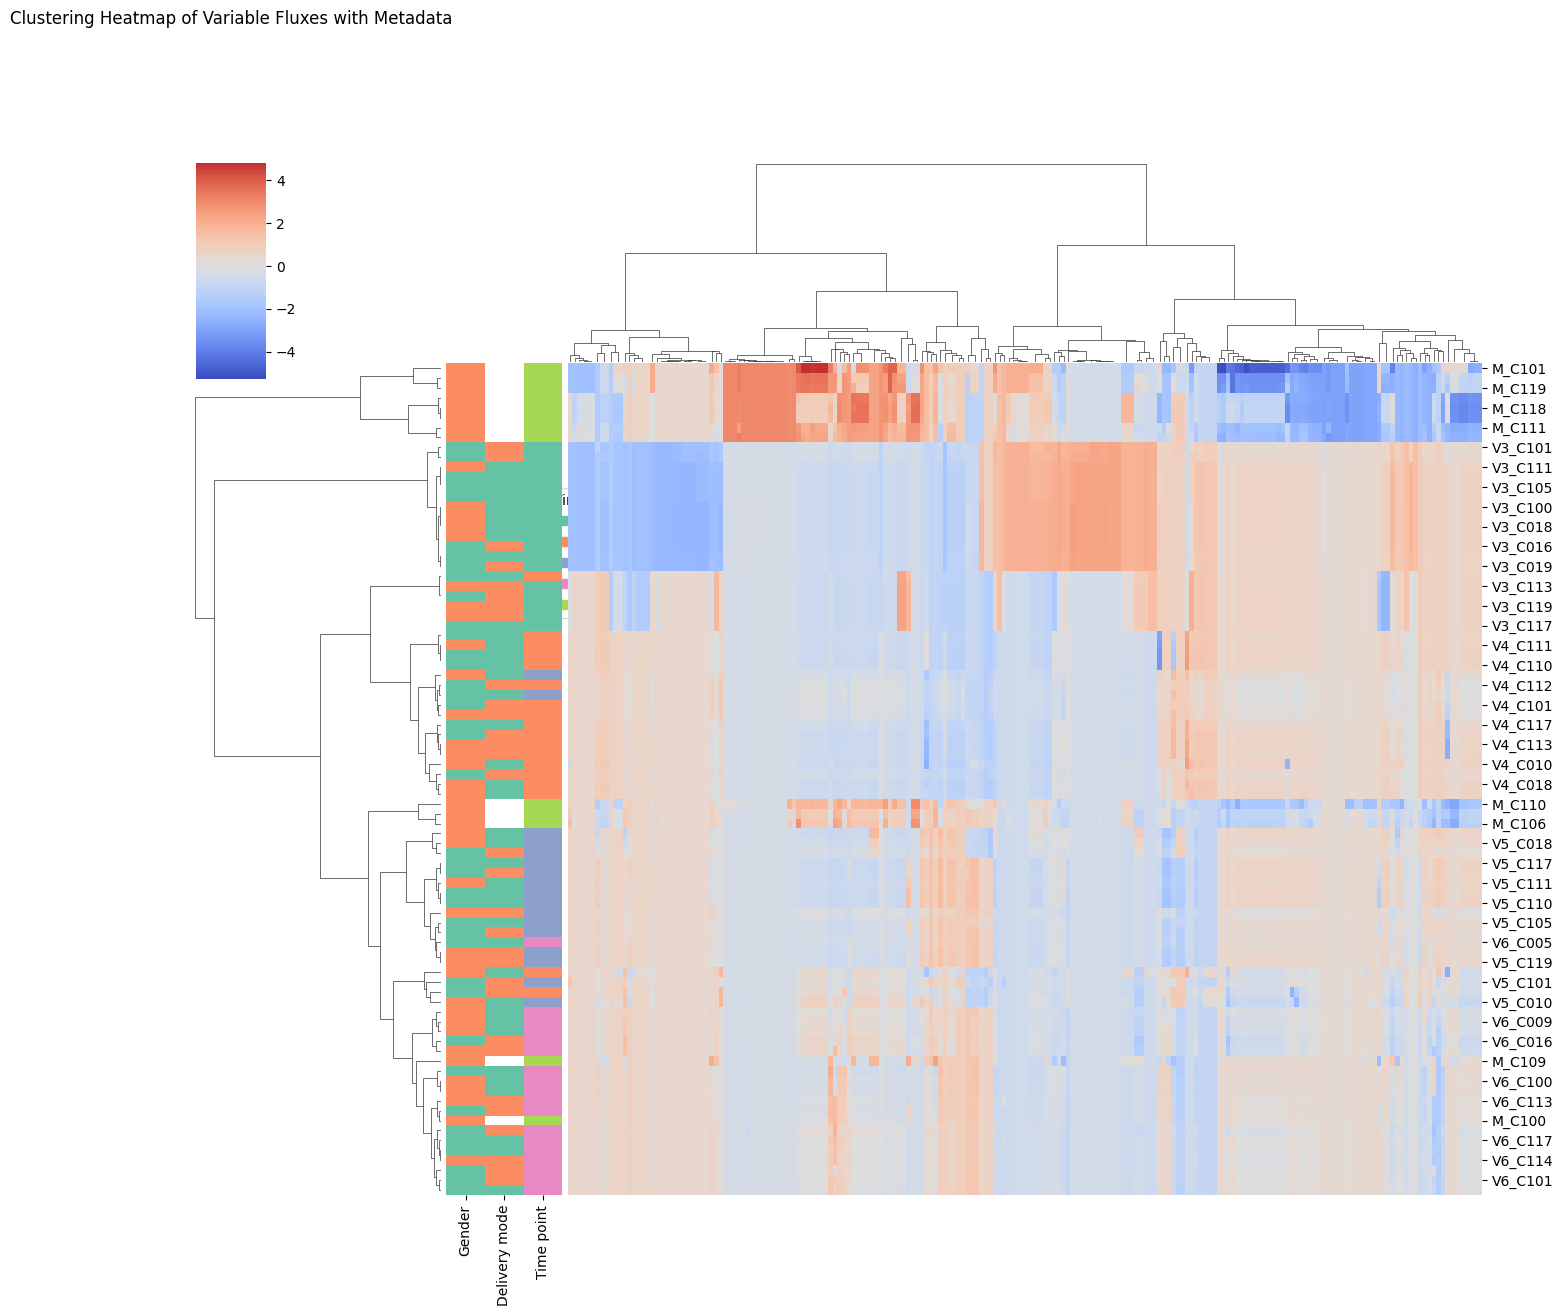

In [31]:
# Step 4: Prepare metadata (make sure metadata index matches df_scaled index)
metadata_subset = metadata.loc[df_scaled.index]
meta_vars = ['Gender', 'Delivery mode', 'Time point']
meta_colors = {}

for var in meta_vars:
    unique_vals = metadata_subset[var].dropna().unique()
    palette = sns.color_palette("Set2", n_colors=len(unique_vals))
    meta_colors[var] = dict(zip(unique_vals, palette))

row_colors = pd.DataFrame({
    var: metadata_subset[var].map(meta_colors[var])
    for var in meta_vars
}, index=metadata_subset.index)

# Step 5: Plot clustermap
g = sns.clustermap(
    df_scaled,
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    center=0,
    figsize=(14, 12),
    row_colors=row_colors
)

# Step 6: Add legends for metadata
for idx, var in enumerate(meta_vars):
    handles = [
        mpatches.Patch(color=color, label=label)
        for label, color in meta_colors[var].items()
    ]
    g.ax_row_dendrogram.legend(
        handles=handles,
        title=var,
        bbox_to_anchor=(1.0 + 0.18 * idx, 0.85),
        loc='upper left',
        borderaxespad=0.
    )

plt.title("Clustering Heatmap of Variable Fluxes with Metadata", pad=100)
# Hide x-axis labels
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.tick_params(axis='x', bottom=False)
plt.show()

C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


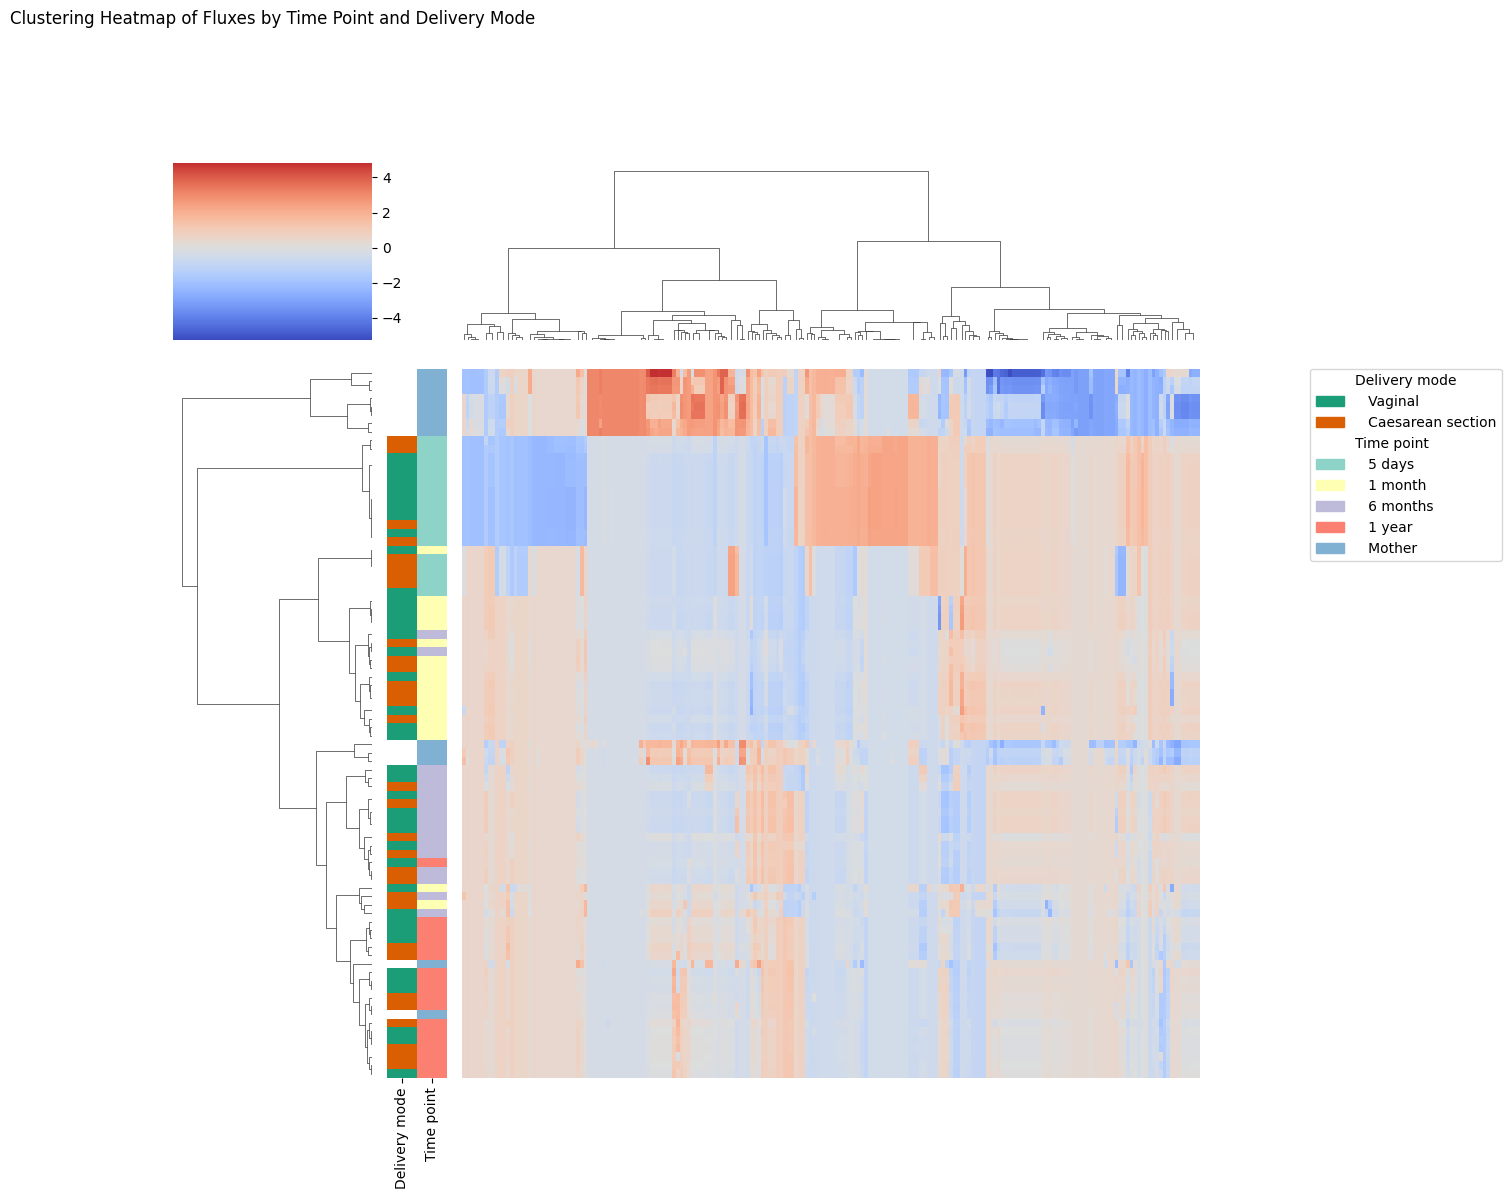

In [32]:
metadata_subset = metadata.loc[df_scaled.index]
meta_vars = ['Delivery mode', 'Time point']
meta_colors = {}

# Use distinct color palettes (not red/blue)
palette_map = {
    'Delivery mode': sns.color_palette("Dark2"),
    'Time point': sns.color_palette("Set3", n_colors=metadata_subset['Time point'].nunique())
}

for var in meta_vars:
    unique_vals = metadata_subset[var].dropna().unique()
    meta_colors[var] = dict(zip(unique_vals, palette_map[var]))

# Create row_colors DataFrame
row_colors = pd.DataFrame({
    var: metadata_subset[var].map(meta_colors[var])
    for var in meta_vars
}, index=metadata_subset.index)

# Step 3: Plot clustermap (with x-axis labels off)
g = sns.clustermap(
    df_scaled,
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    center=0,
    figsize=(14, 12),
    row_colors=row_colors,
    xticklabels=False,
    yticklabels=False
)

# Step 4: Build grouped legend manually
legend_handles = []

# Delivery mode block
legend_handles.append(mpatches.Patch(color='white', label='Delivery mode'))  # Title (white patch, acts as spacer)
for label, color in meta_colors['Delivery mode'].items():
    legend_handles.append(mpatches.Patch(color=color, label=f"   {label}"))  # Indented

# Time point block
legend_handles.append(mpatches.Patch(color='white', label='Time point'))
for label, color in meta_colors['Time point'].items():
    legend_handles.append(mpatches.Patch(color=color, label=f"   {label}"))

# Plot legend to the right of the heatmap
g.ax_heatmap.legend(
    handles=legend_handles,
    title=None,
    bbox_to_anchor=(1.15, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True
)

plt.title("Clustering Heatmap of Fluxes by Time Point and Delivery Mode", pad=100)
plt.tight_layout()
plt.show()

C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


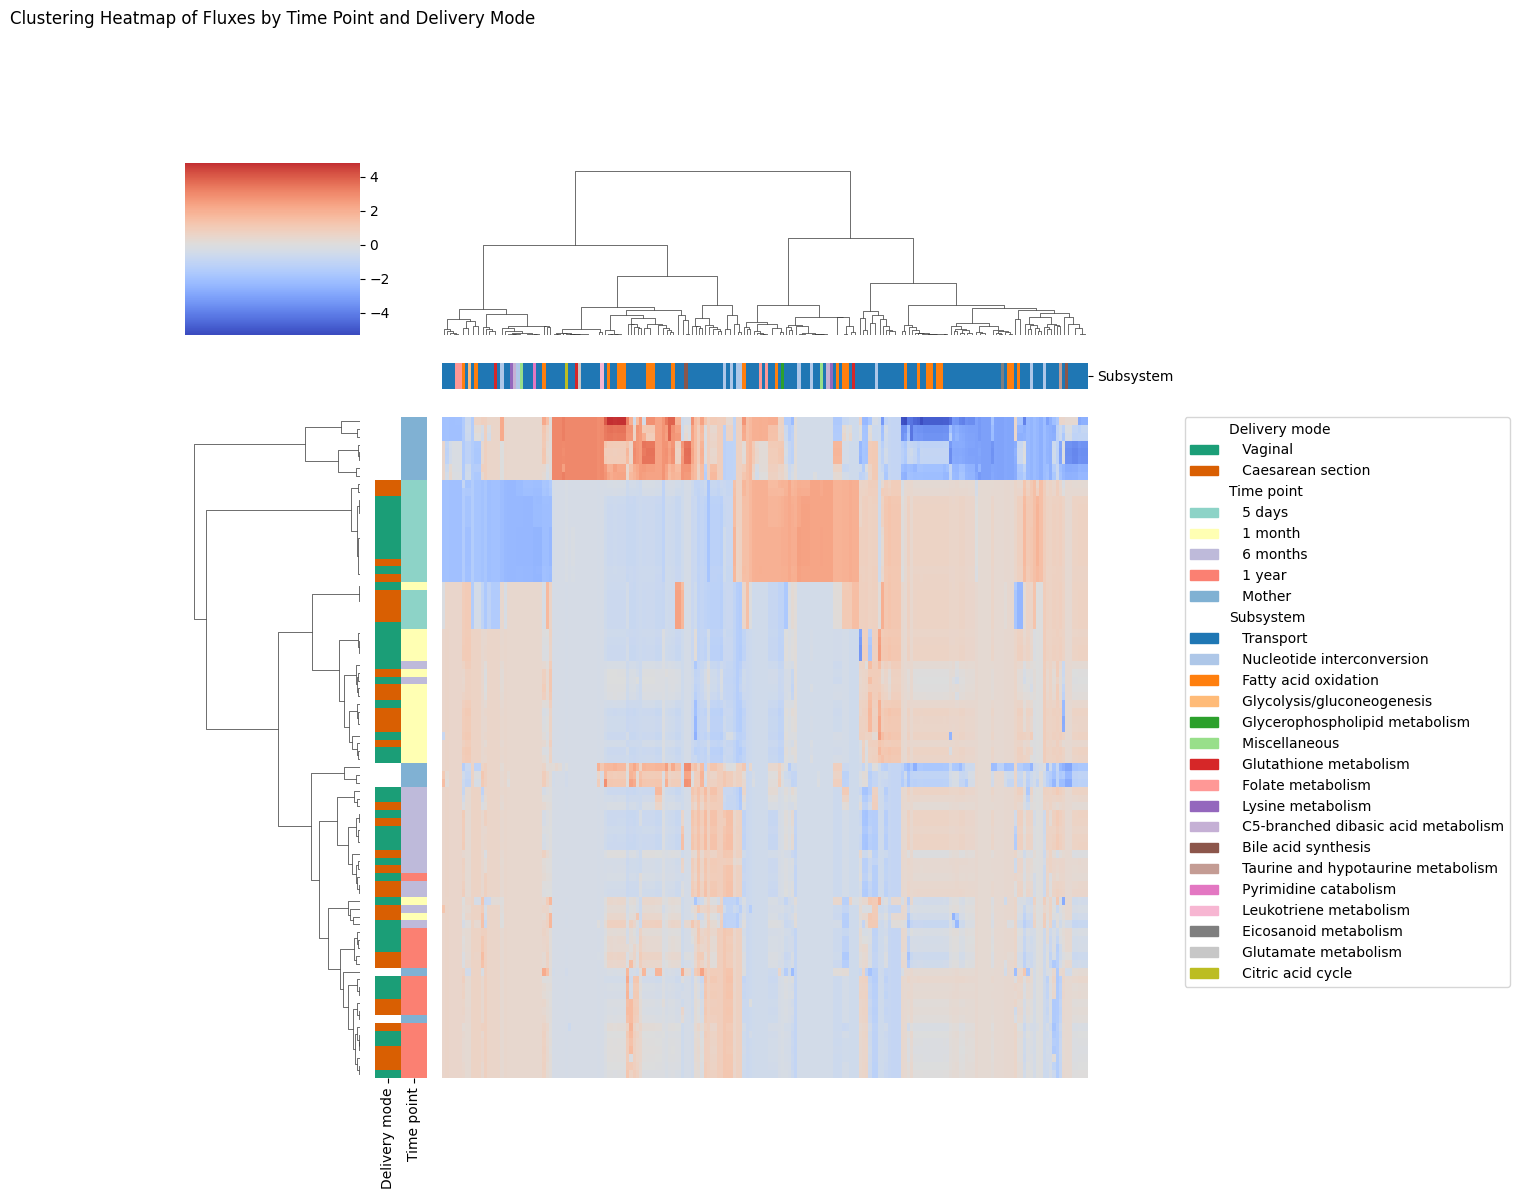

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Ensure metadata subset aligns with df_scaled
metadata_subset = metadata.loc[df_scaled.index]
meta_vars = ['Delivery mode', 'Time point']
meta_colors = {}

# === Define row color palettes ===
palette_map = {
    'Delivery mode': sns.color_palette("Dark2"),
    'Time point': sns.color_palette("Set3", n_colors=metadata_subset['Time point'].nunique())
}

# Map metadata to colors
for var in meta_vars:
    unique_vals = metadata_subset[var].dropna().unique()
    meta_colors[var] = dict(zip(unique_vals, palette_map[var]))

# Create row_colors DataFrame
row_colors = pd.DataFrame({
    var: metadata_subset[var].map(meta_colors[var])
    for var in meta_vars
}, index=metadata_subset.index)

# === Define column color bar for reaction subsystems ===
# Step 1: Create a modified version of rxn2subsystem
rxn2subsystem_grouped = {
    rxn: ('Transport' if 'Transport' in subsystem else subsystem)
    for rxn, subsystem in rxn2subsystem.items()
}
# Map subsystems using rxn2subsystem dict
reaction_subsystems = df_scaled.columns.map(rxn2subsystem_grouped.get)

# Get unique subsystems and assign distinct colors
unique_subsystems = pd.Series(reaction_subsystems).dropna().unique()
subsystem_palette = sns.color_palette("tab20", n_colors=len(unique_subsystems))
subsystem_colors = dict(zip(unique_subsystems, subsystem_palette))

# Build col_colors DataFrame
col_colors = pd.DataFrame({
    'Subsystem': pd.Series(reaction_subsystems, index=df_scaled.columns).map(subsystem_colors)
})

# === Plot clustermap ===
g = sns.clustermap(
    df_scaled,
    metric='euclidean',
    method='ward',
    cmap='coolwarm',
    center=0,
    figsize=(14, 12),
    row_colors=row_colors,
    col_colors=col_colors,
    xticklabels=False,
    yticklabels=False
)

# === Build grouped legend manually ===
legend_handles = []

# Delivery mode block
legend_handles.append(mpatches.Patch(color='white', label='Delivery mode'))  # Title
for label, color in meta_colors['Delivery mode'].items():
    legend_handles.append(mpatches.Patch(color=color, label=f"   {label}"))

# Time point block
legend_handles.append(mpatches.Patch(color='white', label='Time point'))
for label, color in meta_colors['Time point'].items():
    legend_handles.append(mpatches.Patch(color=color, label=f"   {label}"))

# Subsystem block
legend_handles.append(mpatches.Patch(color='white', label='Subsystem'))
for label, color in subsystem_colors.items():
    legend_handles.append(mpatches.Patch(color=color, label=f"   {label}"))

# Add legend
g.ax_heatmap.legend(
    handles=legend_handles,
    title=None,
    bbox_to_anchor=(1.15, 1),
    loc='upper left',
    borderaxespad=0.,
    frameon=True
)

# === Final touches ===
plt.title("Clustering Heatmap of Fluxes by Time Point and Delivery Mode", pad=100)
plt.tight_layout()
plt.show()


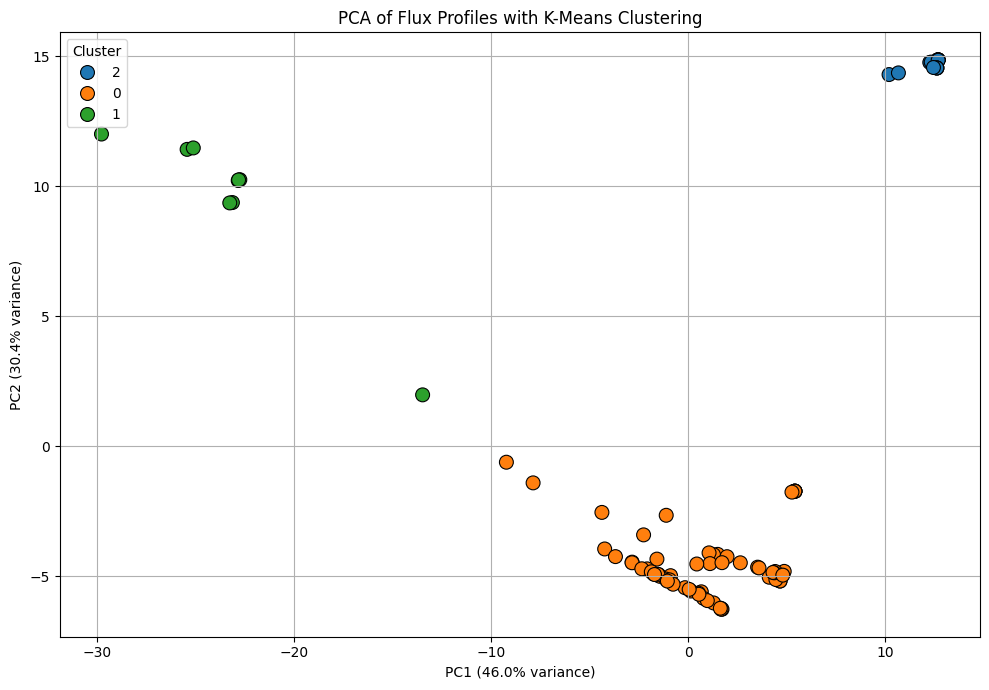

In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=df_scaled.index)

# Step 2: Run KMeans
n_clusters = 3  # Change this depending on how many you want
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pca_result)
pca_df['Cluster'] = clusters.astype(str)

# Step 3: Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Cluster',
    palette='tab10',
    s=100,
    edgecolor='black'
)

plt.title("PCA of Flux Profiles with K-Means Clustering")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Cluster")
plt.show()


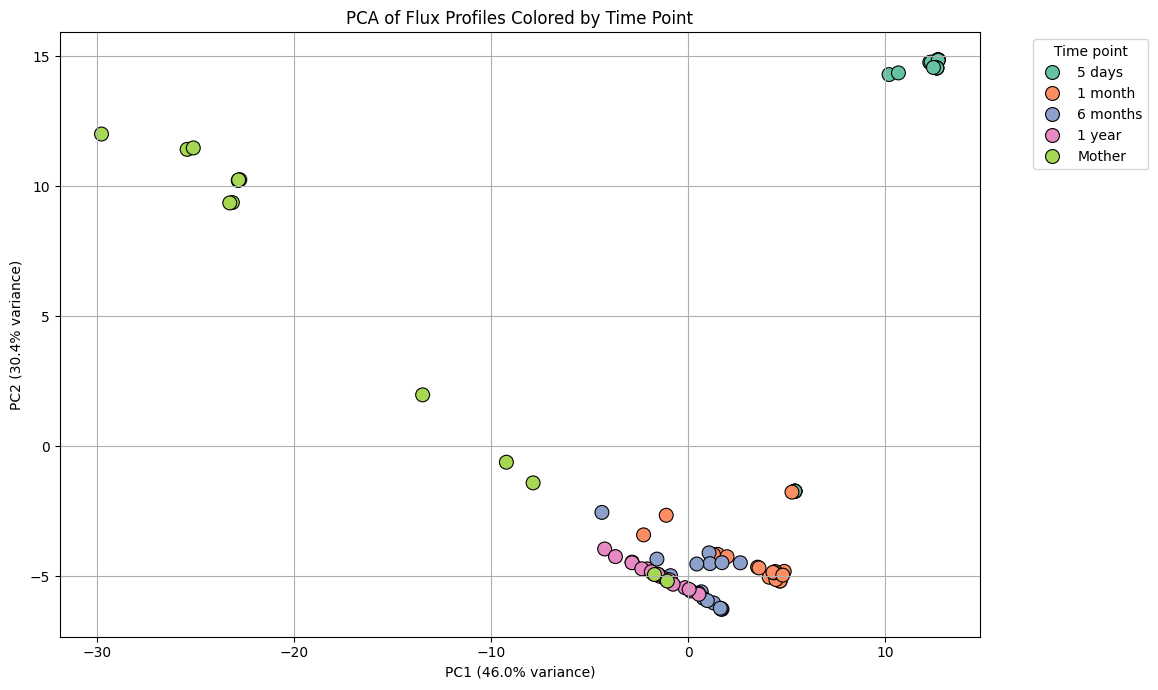

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=df_scaled.index)

# Step 2: Merge Time point from metadata
pca_df = pca_df.join(metadata[['Time point']])

# Step 3: Plot PCA colored by Time point
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Time point',
    palette='Set2',
    s=100,
    edgecolor='black'
)

# Add variance explained
plt.title("PCA of Flux Profiles Colored by Time Point")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Time point", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


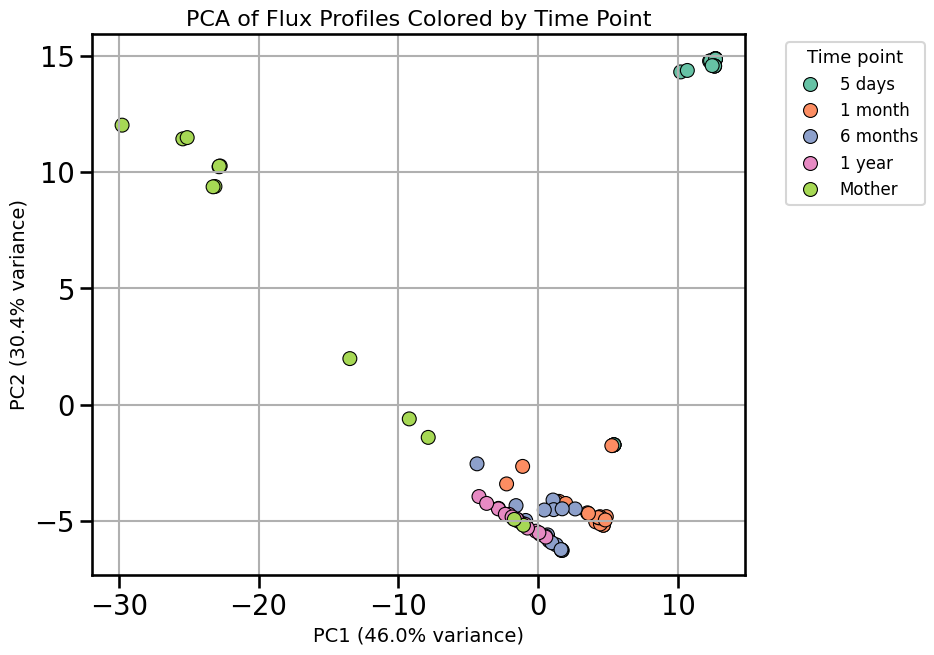

In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=df_scaled.index)

# Step 2: Merge Time point from metadata
pca_df = pca_df.join(metadata[['Time point']])

# Step 3: Plot PCA
plt.figure(figsize=(8, 7))  # Slightly less wide (was 10)
sns.set_context("talk", font_scale=1.2)  # Larger font sizes

sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Time point',
    palette='Set2',
    s=100,
    edgecolor='black'
)

# Add variance explained
plt.title("PCA of Flux Profiles Colored by Time Point", fontsize=16)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)", fontsize=14)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Time point", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=13)
plt.show()


In [206]:
# Step 1: Run PCA again (or reuse existing pca)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Step 2: Get PCA loadings (contributions of each reaction)
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_scaled.columns,
    columns=['PC1', 'PC2']
)

# Step 3: Sort and view top contributors for each PC
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(10)

print("Top contributors to PC1:")
print(top_pc1)

print("\nTop contributors to PC2:")
print(top_pc2)


Top contributors to PC1:
r2110        0.087187
HMR_2760     0.085539
ADRNCRNt     0.085537
H2Otn        0.085505
r2433        0.085096
HMR_2644     0.084633
HPDCACRNt    0.084633
ACRNtm       0.084320
HMR_2757     0.084162
HMR_2634     0.084160
Name: PC1, dtype: float64

Top contributors to PC2:
r2090         0.150422
NADPtru       0.143712
NADPHtru      0.143712
PYRt2p        0.142604
r0783         0.136882
FADtru        0.136882
FADH2tru      0.136882
DHCR242r      0.136882
LNLNCGCPT1    0.134970
r2537         0.134968
Name: PC2, dtype: float64


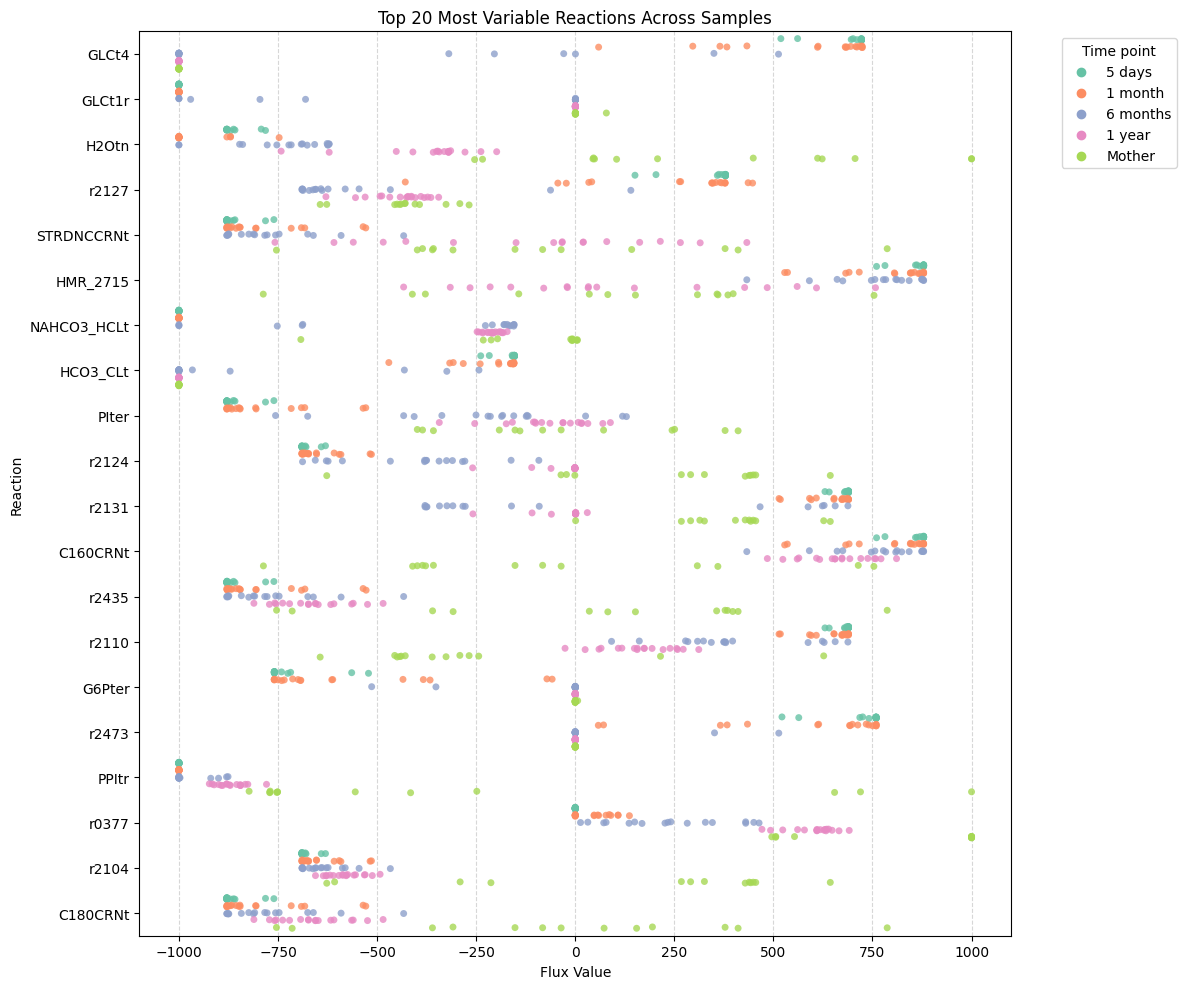

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# === Configurable ===
top_n_reactions = 20  # Change this to show more or fewer reactions

# Step 1: Compute variance and pick top variable reactions
reaction_variance = df.var(axis=0)
top_reactions = reaction_variance.sort_values(ascending=False).head(top_n_reactions).index
df_topvar = df[top_reactions]

# Step 2: Melt the dataframe for seaborn (long format)
df_long = df_topvar.reset_index().melt(id_vars='index', var_name='Reaction', value_name='Flux')
df_long.rename(columns={'index': 'Sample'}, inplace=True)

# Step 3: Add Time point from metadata
df_long = df_long.merge(metadata[['Time point']], left_on='Sample', right_index=True)

# Step 4: Plot using stripplot or swarmplot
plt.figure(figsize=(12, top_n_reactions * 0.5))
sns.stripplot(
    data=df_long,
    x='Flux',
    y='Reaction',
    hue='Time point',
    jitter=True,
    dodge=True,
    alpha=0.8,
    palette='Set2',
    size=5
)

plt.title(f"Top {top_n_reactions} Most Variable Reactions Across Samples")
plt.xlabel("Flux Value")
plt.ylabel("Reaction")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Time point')
plt.tight_layout()
plt.show()


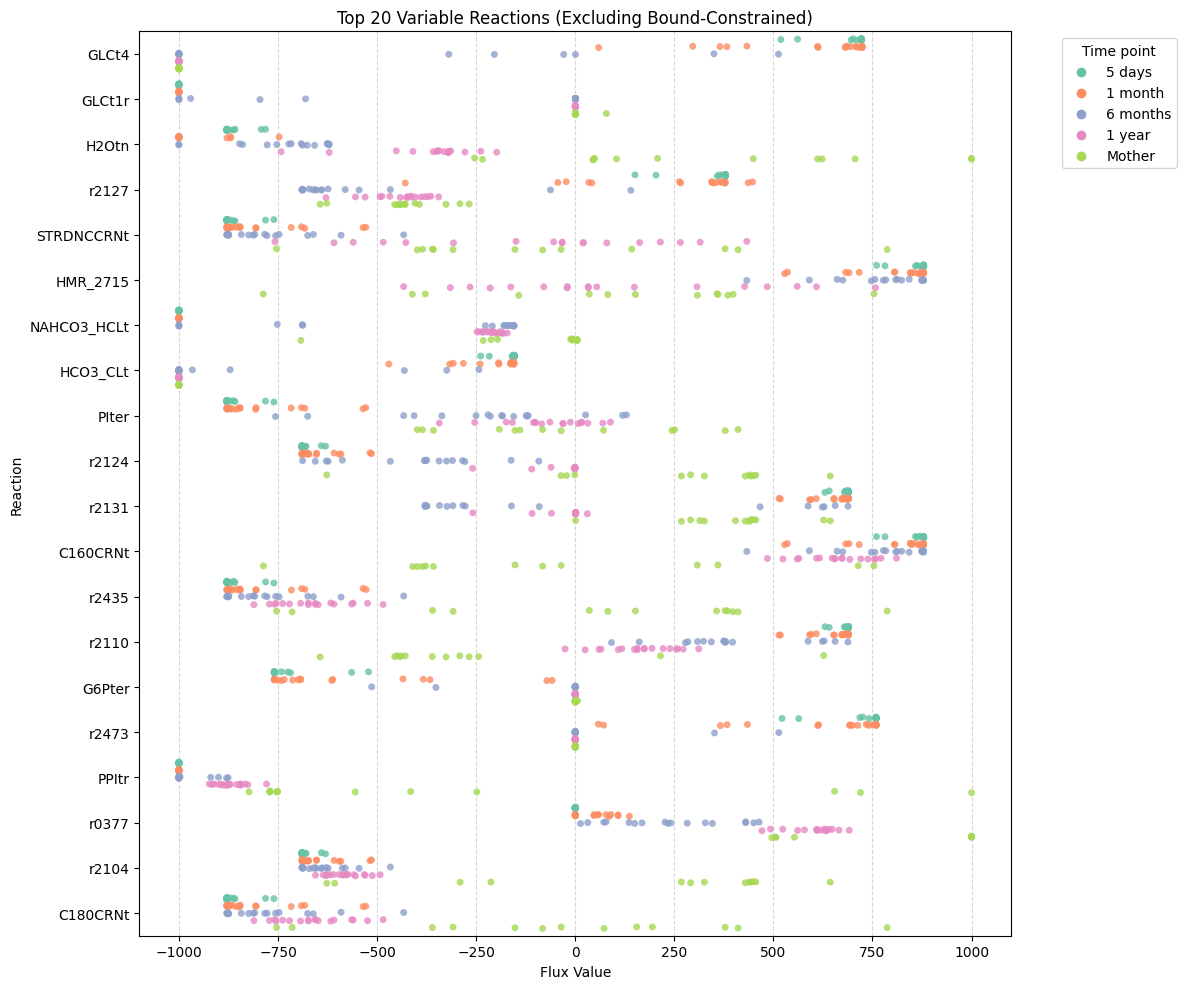

In [208]:
# === Configurable ===
top_n_reactions = 20
exclude_hard_bounds = True
bound_threshold = 950  # Exclude reactions stuck at ±bound_threshold

# Step 1: Compute variance
reaction_variance = df.var(axis=0)

# Step 2: Filter out reactions mostly fixed at upper/lower bounds
if exclude_hard_bounds:
    valid_reactions = []
    for reaction in reaction_variance.index:
        vals = df[reaction]
        unique_vals = vals.unique()
        # If only a few unique values, and all are near bounds → skip
        if len(unique_vals) <= 2 and all(abs(v) >= bound_threshold for v in unique_vals):
            continue
        valid_reactions.append(reaction)
    filtered_variance = reaction_variance.loc[valid_reactions]
else:
    filtered_variance = reaction_variance

# Step 3: Get top N from filtered set
top_reactions = filtered_variance.sort_values(ascending=False).head(top_n_reactions).index
df_topvar = df[top_reactions]

# Step 4: Melt for plotting
df_long = df_topvar.reset_index().melt(id_vars='index', var_name='Reaction', value_name='Flux')
df_long.rename(columns={'index': 'Sample'}, inplace=True)
df_long = df_long.merge(metadata[['Time point']], left_on='Sample', right_index=True)

# Step 5: Plot
plt.figure(figsize=(12, top_n_reactions * 0.5))
sns.stripplot(
    data=df_long,
    x='Flux',
    y='Reaction',
    hue='Time point',
    jitter=True,
    dodge=True,
    alpha=0.8,
    palette='Set2',
    size=5
)

plt.title(f"Top {top_n_reactions} Variable Reactions (Excluding Bound-Constrained)")
plt.xlabel("Flux Value")
plt.ylabel("Reaction")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Time point')
plt.tight_layout()
plt.show()


In [33]:
subsystems = {}

for r in cobraModel.reactions:
    r_id = r.id
    try:
        _ = subsystems[cobraModel.reactions.get_by_id(r_id).subsystem]
    except:
        subsystems[cobraModel.reactions.get_by_id(r_id).subsystem] = set()
    
    
    subsystems[cobraModel.reactions.get_by_id(r_id).subsystem].update([(r_id)])

In [34]:
subsystems

{'Transport, lysosomal': {'10FTHF5GLUtl',
  '10FTHF6GLUtl',
  '10FTHF7GLUtl',
  '10FTHFtl',
  '5DHFtl',
  '5THFtl',
  '6DHFtl',
  '6THFtl',
  '7DHFtl',
  '7THFtl',
  'ABUTt2rL',
  'ACGAGBSIDEtl',
  'ACGALtly',
  'ACGAMtly',
  'ACGBGBSIDEtl',
  'ACNAMlt',
  'ADNtl',
  'ATPasel',
  'CHOLPtl',
  'COAtl',
  'CRVNCtl',
  'CSPG_Atly',
  'CSPG_Btly',
  'CSPG_Ctly',
  'CSPG_Dtly',
  'CSPG_Etly',
  'CYTDtl',
  'DHFtl',
  'DIGALSIDEtl',
  'DPCOAtl',
  'FALDtly',
  'FUCtly',
  'GALGLUSIDEtl',
  'GALSIDEtl',
  'GALtly',
  'GBSIDEtl',
  'GD1Btl',
  'GD3tlc',
  'GLCURtly',
  'GLCtly',
  'GLUt7l',
  'GSNtl',
  'H2O2tly',
  'H2Otly',
  'HAtly',
  'HMR_0769',
  'HMR_0831',
  'HMR_0913',
  'HMR_2087',
  'HMR_2090',
  'HMR_3597',
  'HMR_5249',
  'HMR_7198',
  'HMR_7199',
  'HMR_7711',
  'HMR_7715',
  'HMR_7720',
  'HMR_7724',
  'HMR_7727',
  'HMR_8588',
  'HMR_8590',
  'HSPGtly',
  'IDOURtly',
  'KSII_CORE2tly',
  'KSII_CORE4tly',
  'KSItly',
  'MANtly',
  'MEOHtly',
  'N2M2NMASNtly',
  'NO2te',
  'Rtota

In [35]:
df_filtered

,10FTHFtm,11DOCRTSTRNtm,11DOCRTSTRNtr,2AMACHYD,2HBO,2HBt2,2HCO3_NAt,34HPPOR,3DSPHR,3HAO,...,DM_4abut[c],DM_srtn[c],DM_ach[c],DM_kynate[c],DCMPtm,ATPS4mi,CYOR_u10mi,NADH2_u10mi,CYOOm3i,CYOOm2i
V3_C005,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-980.563779,35.902643,23.606042,0.000000,0.0,12.296601
V3_C009,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
V3_C010,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
V3_C016,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
V3_C018,0.000000,0.000000,0.000000,0.0,0.000000,1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.035978,-974.798723,36.619729,24.084099,0.000000,0.0,12.535630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M_C120,716.084653,0.000000,0.000000,0.0,-0.161985,-1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.000000,-1000.000000,297.405873,198.270582,0.000000,0.0,99.135291
M_C115,764.403518,0.225739,-0.225739,0.0,0.000000,-1000.0,1000.0,0.0,0.004922,0.001017,...,0.0,0.0,0.0,0.000000,-1000.000000,30.961132,20.634940,0.000000,0.0,10.326192
M_C101,0.000000,0.000000,0.000000,0.0,0.000000,-1000.0,1000.0,0.0,0.004922,0.000000,...,0.0,0.0,0.0,0.000000,-1000.000000,294.952116,196.305690,0.000000,0.0,98.646426
M_C114,0.000000,0.000000,0.000000,0.0,0.000000,-1000.0,1000.0,0.0,0.004922,0.002968,...,0.0,0.0,0.0,0.000000,-1000.000000,359.128583,153.431953,128.980654,0.0,76.715976


In [37]:
df_infants = df_filtered[~df_filtered.index.str.startswith("M_")]

In [38]:
microbiome_fluxes

{'V3_C005': 0.003893040293040293,
 'V3_C009': 0.0,
 'V3_C010': 0.0,
 'V3_C016': 0.0,
 'V3_C018': 0.0,
 'V3_C019': 0.0025463372093023256,
 'V3_C100': 0.0,
 'V3_C101': 0.03131871640866878,
 'V3_C105': 0.0,
 'V3_C106': 0.0,
 'V3_C110': 0.0,
 'V3_C111': 0.0012065454545454545,
 'V3_C112': 0.012766272040302265,
 'V3_C113': 0.0,
 'V3_C114': 0.0,
 'V3_C117': 0.0,
 'V3_C119': 0.0,
 'V3_C120': 0.0,
 'V4_C005': 0.0010748222222222222,
 'V4_C009': 0.04255238095238095,
 'V4_C010': 0.0,
 'V4_C016': 0.040494044444444446,
 'V4_C018': 0.0,
 'V4_C019': 0.008518933333333334,
 'V4_C100': 0.0028680952380952377,
 'V4_C101': 0.021722133333333334,
 'V4_C105': 0.0,
 'V4_C106': 0.003804888888888889,
 'V4_C110': 0.0,
 'V4_C111': 0.0015543809523809523,
 'V4_C112': 0.022705244444444442,
 'V4_C113': 0.003717357142857143,
 'V4_C114': 0.004144285714285714,
 'V4_C117': 0.008384533333333333,
 'V4_C119': 0.020096190476190476,
 'V4_C120': 0.0005177555555555556,
 'V5_C005': 0.013420025316455697,
 'V5_C009': 0.0087491506849

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Define root directory
root_dir = "Flux_vs_Butyrate"
os.makedirs(root_dir, exist_ok=True)

# Ensure butyrate flux matches df_infants index
butyrate_series = pd.Series(microbiome_fluxes).reindex(df_infants.index)

# Filter out samples with no butyrate flux
valid_samples = butyrate_series.dropna().index
df_valid = df_infants.loc[valid_samples]
butyrate_flux = butyrate_series.loc[valid_samples]

# Loop through each reaction (column)
for reaction in df_valid.columns:
    y = df_valid[reaction]

    # Skip if all values are 0 or NaN
    if y.isna().all() or (y == 0).all():
        continue

    # Calculate Pearson correlation
    try:
        r, p = pearsonr(butyrate_flux, y)
    except Exception as e:
        print(f"Skipping {reaction} due to error: {e}")
        continue

    # Start plotting
    plt.figure(figsize=(6, 4))
    sns.regplot(x=butyrate_flux, y=y, scatter_kws={'s': 30}, line_kws={'color': 'red'})
    plt.xlabel("Butyrate Flux (mmol/gDW/h)")
    plt.ylabel(f"Flux of {reaction}")
    plt.title(f"{reaction}\nPearson r = {r:.2f}, p = {p:.2e}")
    plt.tight_layout()

    # Determine subsystem and save path
    subsystem = rxn2subsystem.get(reaction, "Unknown_Subsystem")
    sub_dir = os.path.join(root_dir, subsystem)
    os.makedirs(sub_dir, exist_ok=True)
    file_path = os.path.join(sub_dir, f"{reaction}.png")

    plt.savefig(file_path, dpi=300)
    plt.close()


C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\jrp89\miniconda3\envs\cobrapy\lib\site-packages\scipy\stats\_stats_